In [ ]:
import os
import numpy as np
from PIL import Image
from skimage.segmentation import find_boundaries
from scipy.ndimage import distance_transform_edt
import networkx as nx
from Codes.utils import save_graph_txt

def convert_drive_dataset(drive_path, output_path):
    """Convert DRIVE dataset to the format expected by the current pipeline"""
    
    for subset in ['training', 'test']:
        # Create output directories
        os.makedirs(os.path.join(output_path, subset, 'images'), exist_ok=True)
        os.makedirs(os.path.join(output_path, subset, 'dist_labels'), exist_ok=True)
        os.makedirs(os.path.join(output_path, subset, 'graphs'), exist_ok=True)
        
        # Get file lists
        image_dir = os.path.join(drive_path, subset, 'images')
        mask_dir = os.path.join(drive_path, subset, 'mask')
        gt_dir = os.path.join(drive_path, subset, '1st_manual')
        
        image_files = sorted([f for f in os.listdir(image_dir) if f.endswith('.tif')])
        
        for i, img_file in enumerate(image_files):
            base_name = f"data_{i}"
            
            # 1. Process image
            img_path = os.path.join(image_dir, img_file)
            img = np.array(Image.open(img_path), dtype=np.float32)
            
            # Convert to grayscale if RGB
            if img.ndim == 3:
                img = np.mean(img, axis=2)
            
            # 2. Process mask
            mask_file = os.path.join(mask_dir, img_file.replace('.tif', '_mask.gif'))
            if not os.path.exists(mask_file):
                # Try alternative naming pattern
                mask_files = [f for f in os.listdir(mask_dir) if f.endswith('.gif')]
                if i < len(mask_files):
                    mask_file = os.path.join(mask_dir, mask_files[i])
            
            if os.path.exists(mask_file):
                mask = np.array(Image.open(mask_file), dtype=np.float32) / 255.0
                img = img * mask
            
            # 3. Process ground truth
            gt_file = os.path.join(gt_dir, img_file.replace('.tif', '.gif'))
            if not os.path.exists(gt_file):
                # Try alternative naming pattern
                gt_files = [f for f in os.listdir(gt_dir) if f.endswith('.gif')]
                if i < len(gt_files):
                    gt_file = os.path.join(gt_dir, gt_files[i])
            
            gt = np.array(Image.open(gt_file), dtype=np.float32) / 255.0
            
            # 4. Create distance map
            # Binary threshold
            binary_vessels = gt > 0.5
            
            # Distance transform
            dist_map = distance_transform_edt(1 - binary_vessels)
            
            # 5. Create graph representation
            # This is a placeholder - you would implement proper vessel graph extraction
            
            
            # Save files
            np.save(os.path.join(output_path, subset, 'images', f"{base_name}.npy"), img)
            np.save(os.path.join(output_path, subset, 'dist_labels', f"{base_name}.npy"), dist_map)
            save_graph_txt(G, os.path.join(output_path, subset, 'graphs', f"{base_name}.graph"))
            
    print(f"Conversion complete. Files saved to {output_path}")

if __name__ == "__main__":
    convert_drive_dataset(
        drive_path="./drive/training", 
        output_path="./drive/new"
    )

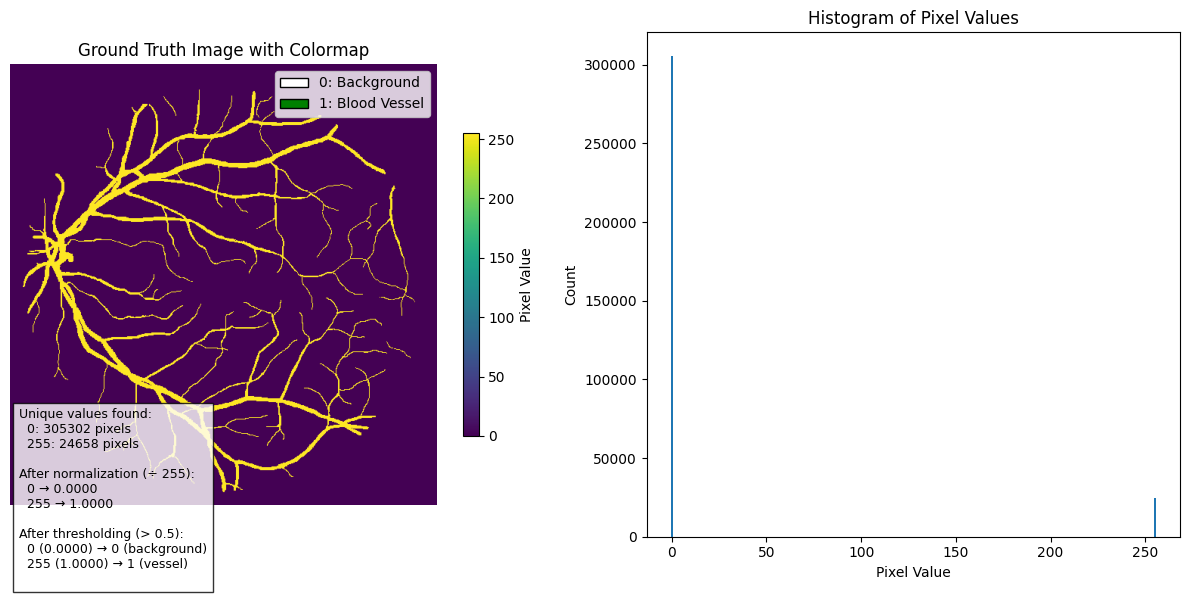

In your processing pipeline:
1. Original values are divided by 255 (gt = np.array(Image.open(gt_file), dtype=np.float32) / 255.0)
2. These are thresholded at 0.5 (binary_vessels = gt > 0.5)
3. Distance map is created from inverted binary image (dist_map = distance_transform_edt(1 - binary_vessels))


In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import matplotlib.colors as mcolors
from matplotlib.patches import Patch

# Path to one of the ground truth images
drive_path = "./drive"  # Change this to your actual path
gt_dir = os.path.join(drive_path, 'training', '1st_manual')

# Get the first GIF file in the directory
try:
    gt_files = [f for f in os.listdir(gt_dir) if f.endswith('.gif')]
    if not gt_files:
        raise FileNotFoundError("No .gif files found in the directory")
    
    gt_file = os.path.join(gt_dir, gt_files[0])
    
    # Load the image
    gt_img = Image.open(gt_file)
    gt_array = np.array(gt_img)
    
    # Create a figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    
    # Plot the original image
    img_plot = ax1.imshow(gt_array, cmap='viridis')
    ax1.set_title('Ground Truth Image with Colormap')
    ax1.axis('off')
    fig.colorbar(img_plot, ax=ax1, shrink=0.6, label='Pixel Value')
    
    # Create a histogram of the values
    unique_values, counts = np.unique(gt_array, return_counts=True)
    ax2.bar(unique_values, counts, width=1)
    ax2.set_xlabel('Pixel Value')
    ax2.set_ylabel('Count')
    ax2.set_title('Histogram of Pixel Values')
    
    # Annotate with actual values found
    value_text = "Unique values found:\n"
    for val, count in zip(unique_values, counts):
        value_text += f"  {val}: {count} pixels\n"
    
    # After normalization (as used in your code)
    value_text += "\nAfter normalization (÷ 255):\n"
    for val in unique_values:
        value_text += f"  {val} → {val/255:.4f}\n"
    
    # Display if these are binary after thresholding
    value_text += "\nAfter thresholding (> 0.5):\n"
    for val in unique_values:
        normalized = val/255
        value_text += f"  {val} ({normalized:.4f}) → {'1 (vessel)' if normalized > 0.5 else '0 (background)'}\n"
    
    plt.figtext(0.02, 0.02, value_text, fontsize=9, 
                bbox=dict(facecolor='white', alpha=0.8))
    
    # Create legend showing the binary mapping
    legend_elements = [
        Patch(facecolor='white', edgecolor='black', label='0: Background'),
        Patch(facecolor='green', edgecolor='black', label='1: Blood Vessel')
    ]
    ax1.legend(handles=legend_elements, loc='upper right')
    
    plt.tight_layout()
    plt.show()
    
    print("In your processing pipeline:")
    print("1. Original values are divided by 255 (gt = np.array(Image.open(gt_file), dtype=np.float32) / 255.0)")
    print("2. These are thresholded at 0.5 (binary_vessels = gt > 0.5)")
    print("3. Distance map is created from inverted binary image (dist_map = distance_transform_edt(1 - binary_vessels))")
    
except FileNotFoundError as e:
    print(f"Error: {e}")
    print("Make sure you have the correct path to the DRIVE dataset.")

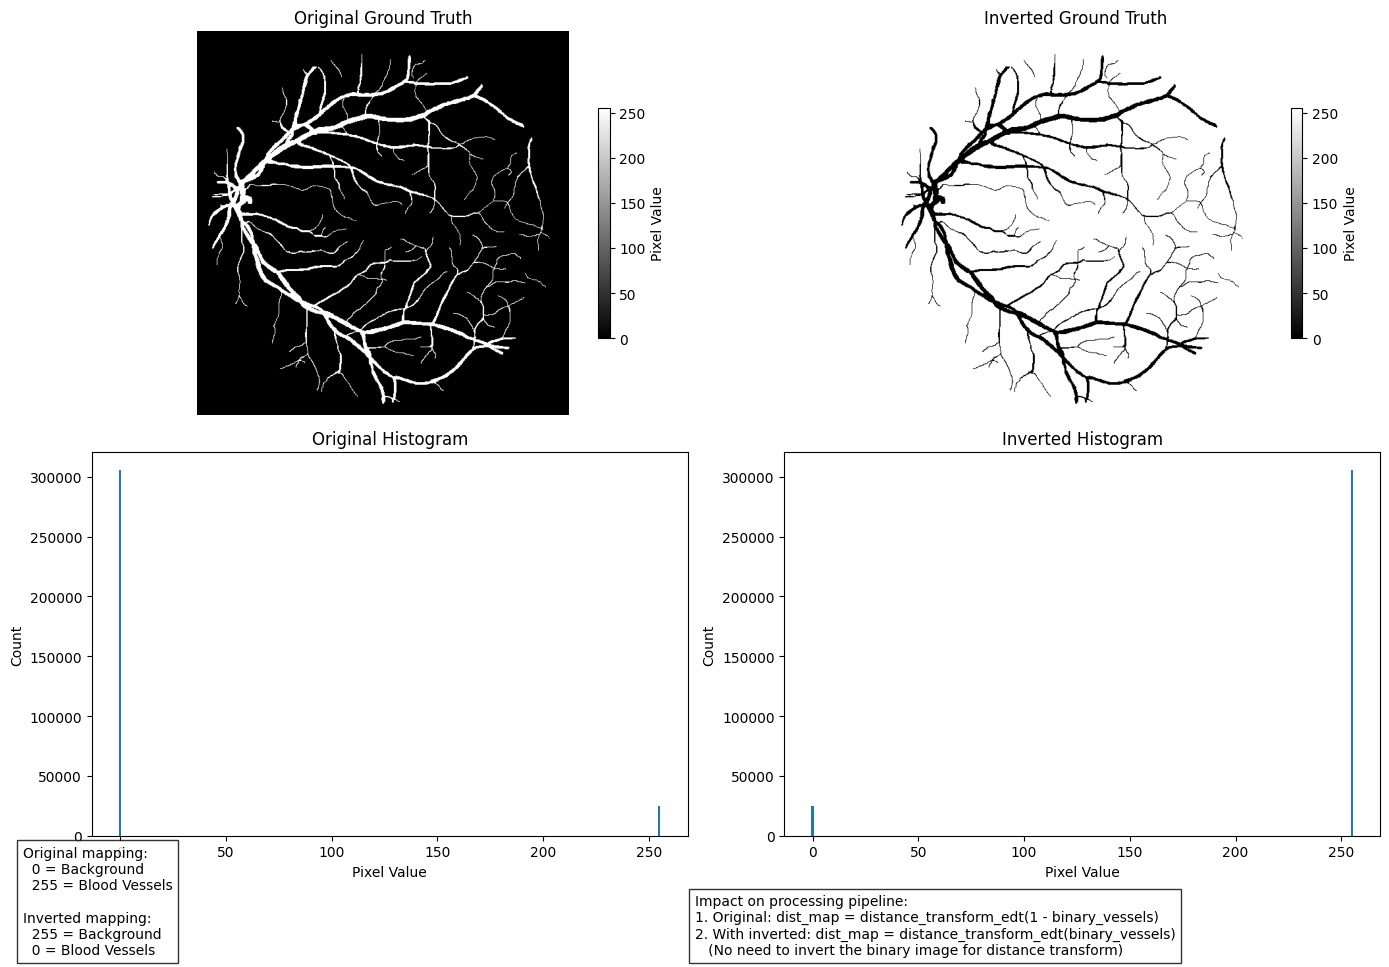

To modify your processing pipeline for inverted ground truth:
1. Invert while loading: gt = np.array(Image.open(gt_file), dtype=np.float32)
2. No need to divide by 255 if you want to keep as integers, or divide if you want normalized values
3. If normalizing, threshold would be: binary_vessels = gt < 0.5  # Note the < instead of >
4. Distance transform would be: dist_map = distance_transform_edt(binary_vessels)  # No need to invert


In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import matplotlib.colors as mcolors
from matplotlib.patches import Patch

# Path to one of the ground truth images
drive_path = "./drive"
gt_dir = os.path.join(drive_path, 'training', '1st_manual')

try:
    gt_files = [f for f in os.listdir(gt_dir) if f.endswith('.gif')]
    if not gt_files:
        raise FileNotFoundError("No .gif files found in the directory")
    
    gt_file = os.path.join(gt_dir, gt_files[0])
    
    # Load the image
    gt_img = Image.open(gt_file)
    gt_array = np.array(gt_img)
    
    # Create inverted image (255 - original)
    inverted_array = 255 - gt_array
    
    # Create a figure with multiple subplots
    fig, axs = plt.subplots(2, 2, figsize=(14, 10))
    
    # Plot original image
    orig_plot = axs[0, 0].imshow(gt_array, cmap='gray')
    axs[0, 0].set_title('Original Ground Truth')
    axs[0, 0].axis('off')
    fig.colorbar(orig_plot, ax=axs[0, 0], shrink=0.6, label='Pixel Value')
    
    # Plot inverted image
    inv_plot = axs[0, 1].imshow(inverted_array, cmap='gray')
    axs[0, 1].set_title('Inverted Ground Truth')
    axs[0, 1].axis('off')
    fig.colorbar(inv_plot, ax=axs[0, 1], shrink=0.6, label='Pixel Value')
    
    # Histograms
    unique_values_orig, counts_orig = np.unique(gt_array, return_counts=True)
    axs[1, 0].bar(unique_values_orig, counts_orig, width=1)
    axs[1, 0].set_xlabel('Pixel Value')
    axs[1, 0].set_ylabel('Count')
    axs[1, 0].set_title('Original Histogram')
    
    unique_values_inv, counts_inv = np.unique(inverted_array, return_counts=True)
    axs[1, 1].bar(unique_values_inv, counts_inv, width=1)
    axs[1, 1].set_xlabel('Pixel Value')
    axs[1, 1].set_ylabel('Count')
    axs[1, 1].set_title('Inverted Histogram')
    
    # Add annotations explaining the inversion
    value_text = "Original mapping:\n"
    value_text += "  0 = Background\n"
    value_text += "  255 = Blood Vessels\n\n"
    value_text += "Inverted mapping:\n"
    value_text += "  255 = Background\n"
    value_text += "  0 = Blood Vessels"
    
    plt.figtext(0.02, 0.02, value_text, fontsize=10, 
                bbox=dict(facecolor='white', alpha=0.8))
    
    # Add impact on processing pipeline
    pipeline_text = "Impact on processing pipeline:\n"
    pipeline_text += "1. Original: dist_map = distance_transform_edt(1 - binary_vessels)\n"
    pipeline_text += "2. With inverted: dist_map = distance_transform_edt(binary_vessels)\n"
    pipeline_text += "   (No need to invert the binary image for distance transform)"
    
    plt.figtext(0.5, 0.02, pipeline_text, fontsize=10,
                bbox=dict(facecolor='white', alpha=0.8))
    
    plt.tight_layout(rect=[0, 0.08, 1, 0.98])
    plt.show()
    
    print("To modify your processing pipeline for inverted ground truth:")
    print("1. Invert while loading: gt = np.array(Image.open(gt_file), dtype=np.float32)")
    print("2. No need to divide by 255 if you want to keep as integers, or divide if you want normalized values")
    print("3. If normalizing, threshold would be: binary_vessels = gt < 0.5  # Note the < instead of >")
    print("4. Distance transform would be: dist_map = distance_transform_edt(binary_vessels)  # No need to invert")
    
except FileNotFoundError as e:
    print(f"Error: {e}")
    print("Make sure you have the correct path to the DRIVE dataset.")

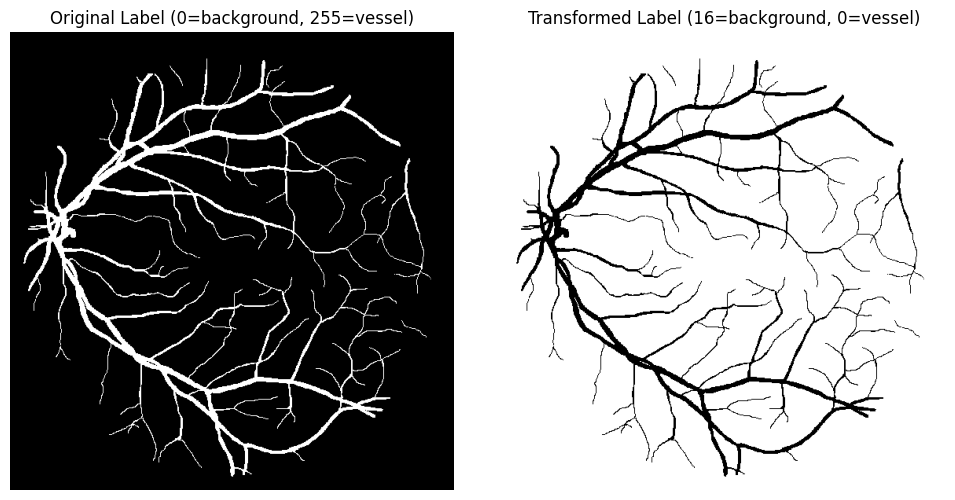

Transformation complete. 20 files processed.
Inverted label files saved to: ./drive\training\inverted_labels

Transformation summary:
  Original labels: 0 = Background, 255 = Blood vessels
  Inverted labels: 16 = Background, 0 = Blood vessels

In your pipeline, you can now:
1. Load these files directly: transformed_label = np.load(file_path)
2. For binary operations: binary_vessels = transformed_label == 0
3. Distance transform: dist_map = distance_transform_edt(binary_vessels)


In [6]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# Path to ground truth images
drive_path = "./drive"
gt_dir = os.path.join(drive_path, 'training', '1st_manual')

# Create output directory for inverted labels
output_dir = os.path.join(drive_path, 'training', 'inverted_labels')
os.makedirs(output_dir, exist_ok=True)

try:
    # Get all GIF files in the directory
    gt_files = [f for f in os.listdir(gt_dir) if f.endswith('.gif')]
    
    if not gt_files:
        raise FileNotFoundError("No .gif files found in the directory")
    
    # Process all files
    for i, filename in enumerate(gt_files):
        gt_file = os.path.join(gt_dir, filename)
        
        # Load the image
        gt_img = Image.open(gt_file)
        gt_array = np.array(gt_img)
        
        # Create transformed array
        # - Original: 0 = background, 255 = vessel
        # - New: 16 = background, 0 = vessel
        transformed_array = np.where(gt_array == 0, 16, 0)
        
        # Save as numpy file
        output_filename = f"{i+21}_manual1.npy"
        np.save(os.path.join(output_dir, output_filename), transformed_array)
        
        # Display first image to verify transformation
        if i == 0:
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
            
            # Original image
            ax1.imshow(gt_array, cmap='gray')
            ax1.set_title('Original Label (0=background, 255=vessel)')
            ax1.axis('off')
            
            # Transformed image
            ax2.imshow(transformed_array, cmap='gray')
            ax2.set_title('Transformed Label (16=background, 0=vessel)')
            ax2.axis('off')
            
            plt.tight_layout()
            plt.show()
    
    print(f"Transformation complete. {len(gt_files)} files processed.")
    print(f"Inverted label files saved to: {output_dir}")
    
    # Print a summary of the transformation
    print("\nTransformation summary:")
    print("  Original labels: 0 = Background, 255 = Blood vessels")
    print("  Inverted labels: 16 = Background, 0 = Blood vessels")
    print("\nIn your pipeline, you can now:")
    print("1. Load these files directly: transformed_label = np.load(file_path)")
    print("2. For binary operations: binary_vessels = transformed_label == 0")
    print("3. Distance transform: dist_map = distance_transform_edt(binary_vessels)")
    
except FileNotFoundError as e:
    print(f"Error: {e}")
    print("Make sure you have the correct path to the DRIVE dataset.")

In [5]:
import os
import numpy as np
from skimage.morphology import skeletonize
import networkx as nx
import Codes.graph_from_skeleton as graph_from_skeleton
import Codes.utils as utils

drive_path = "./drive"
gt_dir    = os.path.join(drive_path, 'training', 'inverted_labels')
out_dir   = os.path.join(drive_path, 'training', 'graphs')
os.makedirs(out_dir, exist_ok=True)

gt_files = [f for f in os.listdir(gt_dir) if f.endswith('.npy')]
if not gt_files:
    raise FileNotFoundError("No .npy files found in the directory")

for fn in gt_files:
    print(f"Processing {fn}…")
    arr = np.load(os.path.join(gt_dir, fn))       # load (H, W), values {0,16}
    vessels = (arr == 0)                          # True = vessel
    sk2d    = skeletonize(vessels)                # 2D skeleton
    # embed in 3‑slice volume so boundary-clearing doesn't kill it
    sk3d    = np.zeros((3,) + sk2d.shape, dtype=np.uint8)
    sk3d[1] = sk2d

    G = graph_from_skeleton.graph_from_skeleton(sk3d, verbose=True)
    if G.number_of_nodes() == 0:
        print(f"  → warning: still empty for {fn}")
        continue

    # ensure pos attribute exists
    for n, data in G.nodes(data=True):
        data.setdefault('pos', np.array([0,0,0], dtype=int))

    utils.save_graph_txt(G, os.path.join(out_dir, fn + '.graph'))
    print(f"  → saved with {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")


Processing 21_manual1.npy…
Creation of densly connected graph.
Pass 0:
	First decimation of nodes.
Remaining nodes: 7773


c:\AdjustingAnnotationswithSnakes\Codes\graph_from_skeleton.py:39: RuntimeWarning: invalid value encountered in arccos
  return np.arccos((p1c*p1c+p0c*p0c-p0p1*p0p1)/(2*p1c*p0c))*180/np.pi


Remaining nodes: 3906
Finished. Remaining nodes: 3906
	First removing close nodes.
Remaining nodes: 3906
Remaining nodes: 3275
Finished. Remaining nodes: 3275
	Removing short danglings.
	Merging close intersections.
Remaining nodes: 3242
Remaining nodes: 2963
Finished. Remaining nodes: 2963
Pass 1:
	First decimation of nodes.
Remaining nodes: 2963
Remaining nodes: 2711
Remaining nodes: 2710
Finished. Remaining nodes: 2710
	First removing close nodes.
Remaining nodes: 2710
Remaining nodes: 2692
Finished. Remaining nodes: 2692
	Removing short danglings.
	Merging close intersections.
Remaining nodes: 2675
Finished. Remaining nodes: 2675
Pass 2:
	First decimation of nodes.
Remaining nodes: 2675
Finished. Remaining nodes: 2675
	First removing close nodes.
Remaining nodes: 2675
Finished. Remaining nodes: 2675
	Removing short danglings.
	Merging close intersections.
Remaining nodes: 2675
Finished. Remaining nodes: 2675
  → saved with 2675 nodes, 2697 edges
Processing 22_manual1.npy…
Creation 

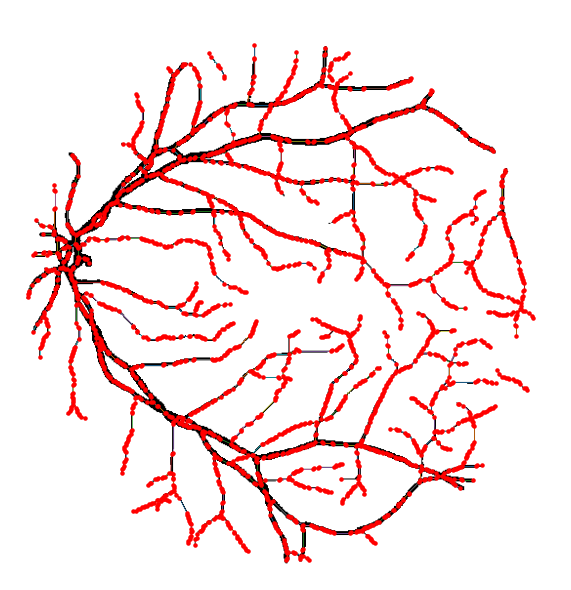

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from skimage.morphology import skeletonize
import Codes.graph_from_skeleton as gfs

def overlay_graph_on_npy(npypath, figsize=(6,6)):
    # 1) load and threshold
    img = np.load(npypath)            # shape (H, W), {0=vessel,16=bg}
    vessels = (img == 0)              # True where vessel
    
    # 2) skeletonize in 2D
    sk2d = skeletonize(vessels)       # binary skeleton
    
    # 3) embed into a 3‑slice volume so pixel_graph won't wipe it out
    sk3d = np.zeros((3,) + sk2d.shape, np.uint8)
    sk3d[1] = sk2d
    
    # 4) rebuild the graph
    G = gfs.graph_from_skeleton(sk3d, verbose=False)
    if G.number_of_nodes() == 0:
        raise RuntimeError(f"Graph is empty for {npypath!r}")
    
    # 5) grab node positions and drop the z
    pos3d = nx.get_node_attributes(G, "pos")   # { node: array([X, Y, Z]) }
    pts2d = { n: (p[0], p[1]) for n,p in pos3d.items() }

    # 6) plot
    plt.figure(figsize=figsize)
    plt.imshow(img, cmap="gray")

    # draw edges
    for u,v in G.edges():
        x1,y1 = pts2d[u]
        x2,y2 = pts2d[v]
        plt.plot([x1,x2], [y1,y2], linewidth=0.5, zorder=1)

    # draw nodes
    xs, ys = zip(*pts2d.values())
    plt.scatter(xs, ys, s=5, c="red", zorder=2)

    plt.axis("off")
    plt.tight_layout()
    plt.show()

# Example usage:
overlay_graph_on_npy("./drive/training/inverted_labels/21_manual1.npy")


In [11]:
import os
import glob

# Path to the directory containing graph files
graph_dir = "./drive/training/mask/"

# List all .graph files
graph_files = glob.glob(os.path.join(graph_dir, "*.gif"))

# Count files before deletion
total_files = len(graph_files)
deleted_count = 0

# Iterate through files and delete those that don't have .npy.graph extension
for file_path in graph_files:
    os.remove(file_path)
    deleted_count += 1
    print(f"Deleted: {os.path.basename(file_path)}")

# Print summary
print(f"\nOperation complete: {deleted_count} files deleted out of {total_files} .graph files.")
print(f"Remaining files: {total_files - deleted_count}")

Deleted: 37_training_mask.gif
Deleted: 32_training_mask.gif
Deleted: 36_training_mask.gif
Deleted: 33_training_mask.gif
Deleted: 35_training_mask.gif
Deleted: 29_training_mask.gif
Deleted: 30_training_mask.gif
Deleted: 34_training_mask.gif
Deleted: 28_training_mask.gif
Deleted: 31_training_mask.gif
Deleted: 38_training_mask.gif
Deleted: 24_training_mask.gif
Deleted: 21_training_mask.gif
Deleted: 39_training_mask.gif
Deleted: 25_training_mask.gif
Deleted: 40_training_mask.gif
Deleted: 26_training_mask.gif
Deleted: 23_training_mask.gif
Deleted: 27_training_mask.gif
Deleted: 22_training_mask.gif

Operation complete: 20 files deleted out of 20 .graph files.
Remaining files: 0


In [3]:
import os
import numpy as np
from PIL import Image

def convert_gifs_to_npy(input_dir):
    """
    Converts all .gif files in the specified directory to .npy files.

    Args:
        input_dir (str): The path to the directory containing the .gif files.
    """
    if not os.path.isdir(input_dir):
        print(f"Error: Directory not found - {input_dir}")
        return

    print(f"Scanning directory: {input_dir}")
    converted_count = 0
    skipped_count = 0

    for filename in os.listdir(input_dir):
        if filename.lower().endswith(".gif"):
            gif_path = os.path.join(input_dir, filename)
            npy_filename = os.path.splitext(filename)[0] + ".npy"
            npy_path = os.path.join(input_dir, npy_filename)

            try:
                # Open the GIF image
                img = Image.open(gif_path)

                # Convert to NumPy array
                img_array = np.array(img)

                # Save as .npy file
                np.save(npy_path, img_array)
                print(f"Converted: {filename} -> {npy_filename}")
                converted_count += 1

            except Exception as e:
                print(f"Error converting {filename}: {e}")
                skipped_count += 1

    print(f"\nConversion complete.")
    print(f"  Successfully converted: {converted_count}")
    print(f"  Skipped/Errors: {skipped_count}")

# Specify the directory containing the .gif files
mask_dir = "./drive/training/mask/"

# Run the conversion
convert_gifs_to_npy(mask_dir)

Scanning directory: ./drive/training/mask/
Converted: 37_training_mask.gif -> 37_training_mask.npy
Converted: 32_training_mask.gif -> 32_training_mask.npy
Converted: 36_training_mask.gif -> 36_training_mask.npy
Converted: 33_training_mask.gif -> 33_training_mask.npy
Converted: 35_training_mask.gif -> 35_training_mask.npy
Converted: 29_training_mask.gif -> 29_training_mask.npy
Converted: 30_training_mask.gif -> 30_training_mask.npy
Converted: 34_training_mask.gif -> 34_training_mask.npy
Converted: 28_training_mask.gif -> 28_training_mask.npy
Converted: 31_training_mask.gif -> 31_training_mask.npy
Converted: 38_training_mask.gif -> 38_training_mask.npy
Converted: 24_training_mask.gif -> 24_training_mask.npy
Converted: 21_training_mask.gif -> 21_training_mask.npy
Converted: 39_training_mask.gif -> 39_training_mask.npy
Converted: 25_training_mask.gif -> 25_training_mask.npy
Converted: 40_training_mask.gif -> 40_training_mask.npy
Converted: 26_training_mask.gif -> 26_training_mask.npy
Conve

Found 20 .npy files. Plotting the first 3...


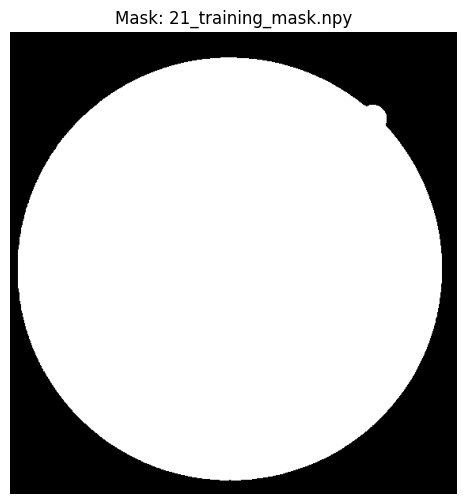

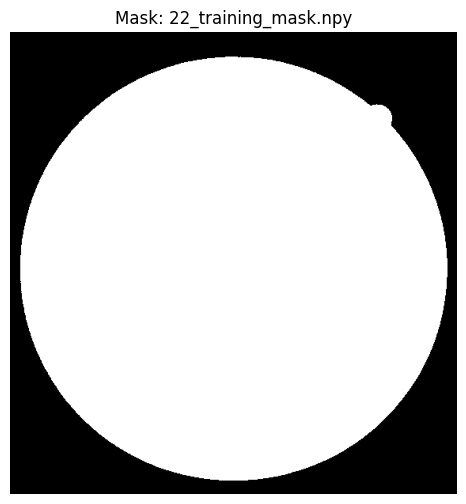

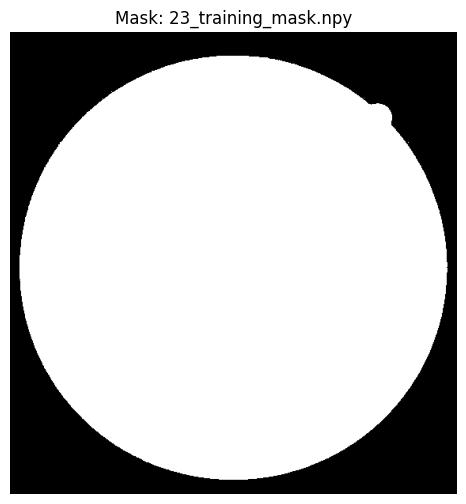

In [10]:
import os
import numpy as np
import matplotlib.pyplot as plt
import glob

def plot_npy_images(npy_dir, num_images_to_plot=5):
    """
    Loads and plots .npy image files from a specified directory.

    Args:
        npy_dir (str): The path to the directory containing the .npy files.
        num_images_to_plot (int): Maximum number of images to plot.
    """
    if not os.path.isdir(npy_dir):
        print(f"Error: Directory not found - {npy_dir}")
        return

    npy_files = sorted(glob.glob(os.path.join(npy_dir, "*.npy")))

    if not npy_files:
        print(f"No .npy files found in {npy_dir}")
        return

    print(f"Found {len(npy_files)} .npy files. Plotting the first {min(num_images_to_plot, len(npy_files))}...")

    for i, npy_path in enumerate(npy_files):
        if i >= num_images_to_plot:
            break

        try:
            # Load the .npy file
            img_array = np.load(npy_path)

            # Plot the image
            plt.figure(figsize=(6, 6))
            plt.imshow(img_array, cmap='gray') # Assuming grayscale mask images
            plt.title(f"Mask: {os.path.basename(npy_path)}")
            plt.axis('off')
            plt.show()

        except Exception as e:
            print(f"Error plotting {os.path.basename(npy_path)}: {e}")

# Specify the directory containing the .npy mask files
mask_npy_dir = "./drive/training/mask/"

# Run the plotting function
plot_npy_images(mask_npy_dir, num_images_to_plot=3) # Plot the first 3 images

In [13]:
import os
import numpy as np
import glob

def analyze_npy_values(npy_dir, num_images_to_analyze=5):
    """
    Loads .npy image files from a specified directory and prints their unique pixel values and counts.

    Args:
        npy_dir (str): The path to the directory containing the .npy files.
        num_images_to_analyze (int): Maximum number of images to analyze.
    """
    if not os.path.isdir(npy_dir):
        print(f"Error: Directory not found - {npy_dir}")
        return

    npy_files = sorted(glob.glob(os.path.join(npy_dir, "*.npy")))

    if not npy_files:
        print(f"No .npy files found in {npy_dir}")
        return

    print(f"Found {len(npy_files)} .npy files. Analyzing the first {min(num_images_to_analyze, len(npy_files))}...")
    print("-" * 30)

    for i, npy_path in enumerate(npy_files):
        if i >= num_images_to_analyze:
            break

        try:
            # Load the .npy file
            img_array = np.load(npy_path)

            # Get unique values and their counts
            unique_values, counts = np.unique(img_array, return_counts=True)

            print(f"File: {os.path.basename(npy_path)}")
            print(f"  Shape: {img_array.shape}")
            print(f"  Data type: {img_array.dtype}")
            print("  Unique values and counts:")
            for value, count in zip(unique_values, counts):
                print(f"    Value: {value}, Count: {count}")
            print("-" * 30)

        except Exception as e:
            print(f"Error analyzing {os.path.basename(npy_path)}: {e}")
            print("-" * 30)

# Specify the directory containing the .npy mask files
mask_npy_dir = "./drive/training/images/"

# Run the analysis function
analyze_npy_values(mask_npy_dir, num_images_to_analyze=3) # Analyze the first 3 images

Found 20 .npy files. Analyzing the first 3...
------------------------------
File: 21_training.npy
  Shape: (584, 565, 3)
  Data type: uint8
  Unique values and counts:
    Value: 0, Count: 19814
    Value: 1, Count: 1363
    Value: 2, Count: 630
    Value: 3, Count: 1005
    Value: 4, Count: 3308
    Value: 5, Count: 13654
    Value: 6, Count: 40302
    Value: 7, Count: 84019
    Value: 8, Count: 85708
    Value: 9, Count: 41616
    Value: 10, Count: 12740
    Value: 11, Count: 3830
    Value: 12, Count: 1683
    Value: 13, Count: 873
    Value: 14, Count: 520
    Value: 15, Count: 351
    Value: 16, Count: 214
    Value: 17, Count: 167
    Value: 18, Count: 127
    Value: 19, Count: 103
    Value: 20, Count: 108
    Value: 21, Count: 119
    Value: 22, Count: 114
    Value: 23, Count: 112
    Value: 24, Count: 97
    Value: 25, Count: 87
    Value: 26, Count: 85
    Value: 27, Count: 98
    Value: 28, Count: 88
    Value: 29, Count: 85
    Value: 30, Count: 91
    Value: 31, Count: 9

In [12]:
import os
import numpy as np
from PIL import Image

def convert_tif_to_npy(input_dir):
    """
    Converts all .tif images in the specified directory to .npy format.

    Args:
        input_dir (str): The path to the directory containing .tif images.
    """
    if not os.path.isdir(input_dir):
        print(f"Error: Directory not found - {input_dir}")
        return

    print(f"Scanning directory: {input_dir}")
    for filename in os.listdir(input_dir):
        if filename.lower().endswith(".tif") or filename.lower().endswith(".tiff"):
            tif_filepath = os.path.join(input_dir, filename)
            npy_filename = os.path.splitext(filename)[0] + ".npy"
            npy_filepath = os.path.join(input_dir, npy_filename)

            try:
                # Open the TIFF image
                with Image.open(tif_filepath) as img:
                    # Convert the image to a NumPy array
                    img_array = np.array(img)

                    # Save the NumPy array as a .npy file
                    np.save(npy_filepath, img_array)
                    os.remove(tif_filepath)
                    print(f"Converted '{tif_filepath}' to '{npy_filepath}'")

            except Exception as e:
                print(f"Error converting file {tif_filepath}: {e}")

# Specify the directory containing the .tif files
image_directory = "./drive/training/images/"

# Run the conversion
convert_tif_to_npy(image_directory)

print("Conversion process finished.")

Scanning directory: ./drive/training/images/
Converted './drive/training/images/29_training.tif' to './drive/training/images/29_training.npy'
Converted './drive/training/images/28_training.tif' to './drive/training/images/28_training.npy'
Converted './drive/training/images/22_training.tif' to './drive/training/images/22_training.npy'
Converted './drive/training/images/25_training.tif' to './drive/training/images/25_training.npy'
Converted './drive/training/images/30_training.tif' to './drive/training/images/30_training.npy'
Converted './drive/training/images/37_training.tif' to './drive/training/images/37_training.npy'
Converted './drive/training/images/40_training.tif' to './drive/training/images/40_training.npy'
Converted './drive/training/images/36_training.tif' to './drive/training/images/36_training.npy'
Converted './drive/training/images/31_training.tif' to './drive/training/images/31_training.npy'
Converted './drive/training/images/24_training.tif' to './drive/training/images/24

In [11]:
import os
import numpy as np
import glob

# Directory containing the mask files
mask_dir = "./drive/training/mask/"

print(f"Processing files in: {mask_dir}")

# Find all .npy files in the directory
npy_files = glob.glob(os.path.join(mask_dir, "*.npy"))

if not npy_files:
    print("No .npy files found in the directory.")
else:
    processed_count = 0
    error_count = 0
    for npy_path in npy_files:
        try:
            # Load the array
            mask_array = np.load(npy_path)

            # Check if the array contains only 0s and 255s (optional but good practice)
            unique_vals = np.unique(mask_array)
            if not np.all(np.isin(unique_vals, [0, 255])):
                 print(f"  Skipping {os.path.basename(npy_path)}: Contains values other than 0 and 255 ({unique_vals}).")
                 continue # Skip this file if it has unexpected values

            # Invert the values: 0 -> 255, 255 -> 0
            inverted_array = np.where(mask_array == 0, 255, 0).astype(mask_array.dtype) # Keep original dtype

            # Save the inverted array back to the original file
            np.save(npy_path, inverted_array)
            print(f"  Inverted values in: {os.path.basename(npy_path)}")
            processed_count += 1

        except Exception as e:
            print(f"  Error processing {os.path.basename(npy_path)}: {e}")
            error_count += 1

    print(f"\nProcessing complete.")
    print(f"  Successfully processed: {processed_count} files")
    print(f"  Errors encountered: {error_count}")
    print(f"  Files skipped (unexpected values): {len(npy_files) - processed_count - error_count}")


Processing files in: ./drive/training/mask/
  Inverted values in: 37_training_mask.npy
  Inverted values in: 32_training_mask.npy
  Inverted values in: 36_training_mask.npy
  Inverted values in: 33_training_mask.npy
  Inverted values in: 29_training_mask.npy
  Inverted values in: 35_training_mask.npy
  Inverted values in: 30_training_mask.npy
  Inverted values in: 28_training_mask.npy
  Inverted values in: 34_training_mask.npy
  Inverted values in: 31_training_mask.npy
  Inverted values in: 24_training_mask.npy
  Inverted values in: 38_training_mask.npy
  Inverted values in: 21_training_mask.npy
  Inverted values in: 25_training_mask.npy
  Inverted values in: 39_training_mask.npy
  Inverted values in: 40_training_mask.npy
  Inverted values in: 26_training_mask.npy
  Inverted values in: 23_training_mask.npy
  Inverted values in: 27_training_mask.npy
  Inverted values in: 22_training_mask.npy

Processing complete.
  Successfully processed: 20 files
  Errors encountered: 0
  Files skipped

In [3]:
b = np.load("./drive/training/mask/34_training_mask.npy")

In [4]:
b

array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], shape=(584, 565), dtype=uint8)

In [5]:
np.unique(b)

array([  0, 255], dtype=uint8)

In [6]:
def show(img,title,graph=None):
    plt.figure(figsize=(10,10))
    plt.suptitle(title)
    
    plt.imshow(img,cmap="coolwarm")
    plt.colorbar()
    if graph:
        pos = {n:graph.nodes[n]['pos'][-1::-1] for n in graph.nodes()}
        nx.draw_networkx(graph, pos=pos, node_size=16, node_color='gray',
                         edge_color='g', font_size=12, font_color='black')
    plt.show()

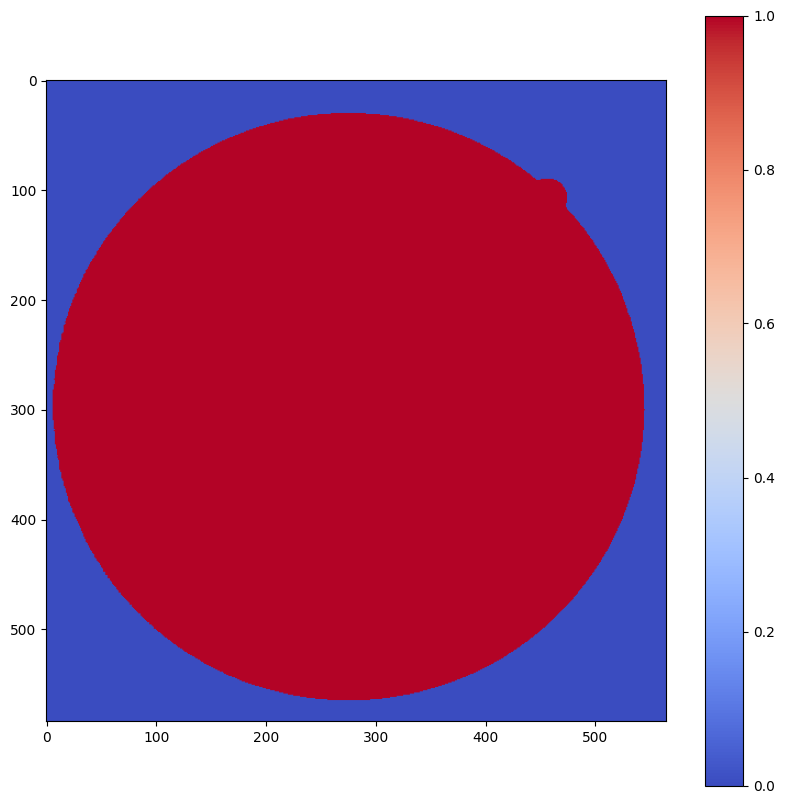

In [8]:
show((b==0),"")

In [ ]:
from Codes.utils import load_graph_txt

graph = load_graph_txt(".drive/training/graphs/21_manual1.npy.graph")

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Found 20 matching label/graph pairs.
Plotting the first 3 examples...

Plotting example 1:
  Label: ./drive/training/inverted_labels/21_manual1.npy
  Graph: ./drive/training/graphs/21_manual1.npy.graph


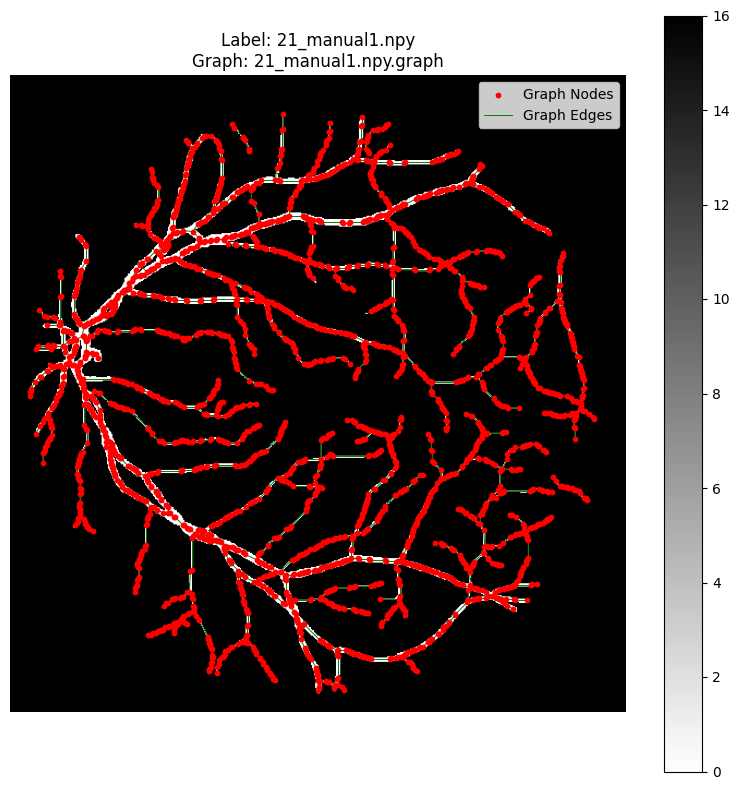


Plotting example 2:
  Label: ./drive/training/inverted_labels/22_manual1.npy
  Graph: ./drive/training/graphs/22_manual1.npy.graph


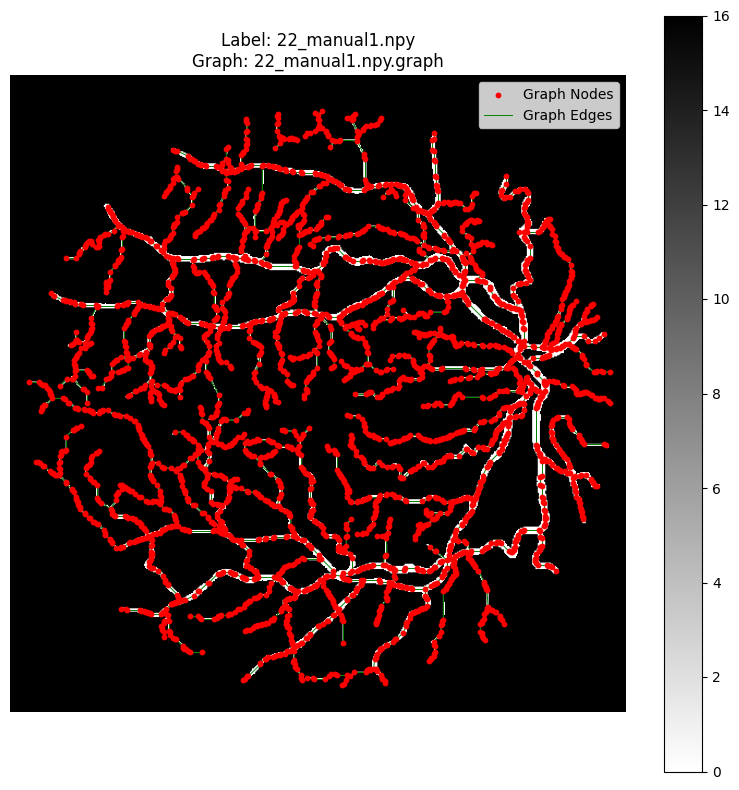


Plotting example 3:
  Label: ./drive/training/inverted_labels/23_manual1.npy
  Graph: ./drive/training/graphs/23_manual1.npy.graph


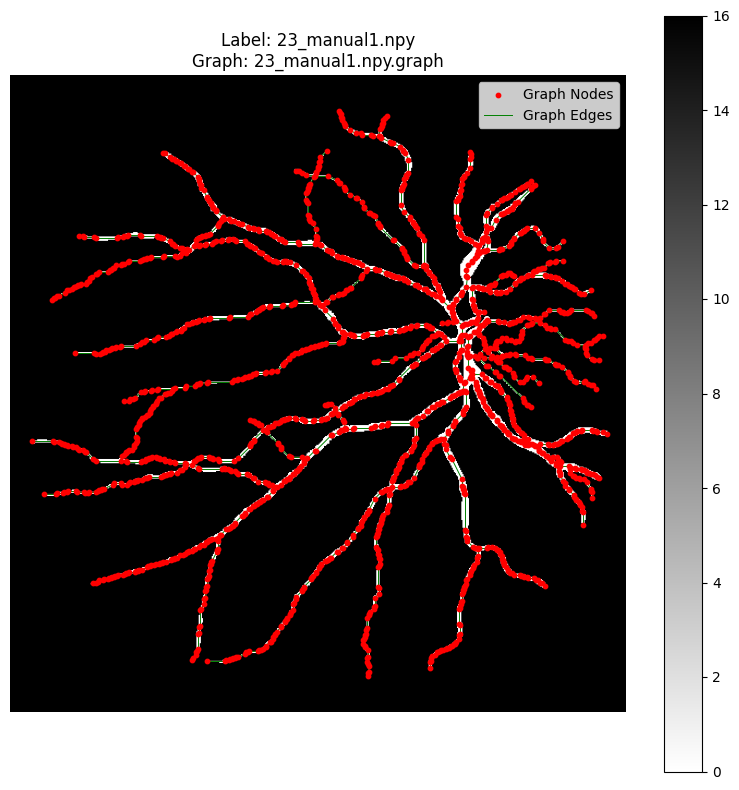

In [9]:
%pip install networkx
%pip install pyyaml
%pip install torch
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from Codes.utils import load_graph_txt


# Define directories
label_dir = "./drive/training/inverted_labels/"
graph_dir = "./drive/training/graphs/"
num_examples_to_plot = 3

# Find corresponding label and graph files
label_files = sorted(glob.glob(os.path.join(label_dir, "*.npy")))
graph_files = sorted(glob.glob(os.path.join(graph_dir, "*.npy.graph"))) # Assuming .npy.graph extension

# Ensure we have pairs
label_basenames = {os.path.basename(f).replace(".npy", ""): f for f in label_files}
graph_basenames = {os.path.basename(f).replace(".npy.graph", ""): f for f in graph_files}

common_basenames = sorted(list(label_basenames.keys() & graph_basenames.keys()))

print(f"Found {len(common_basenames)} matching label/graph pairs.")
print(f"Plotting the first {min(num_examples_to_plot, len(common_basenames))} examples...")

# Plot the first few examples
for i, basename in enumerate(common_basenames):
    if i >= num_examples_to_plot:
        break

    label_path = label_basenames[basename]
    graph_path = graph_basenames[basename]

    print(f"\nPlotting example {i+1}:")
    print(f"  Label: {label_path}")
    print(f"  Graph: {graph_path}")

    try:
        # Load label image
        label_img = np.load(label_path) # Values are 0 for vessel, 16 for background

        # Load graph
        try:
            G = load_graph_txt(graph_path)
        except ValueError as e:
            # Specifically catch the coordinate unpacking error during loading
            if "not enough values to unpack" in str(e):
                print(f"  Skipping {basename}: Error loading graph - Mismatch between expected (3) and found (2) coordinates in load_graph_txt. ({e})")
                continue # Skip this example
            else:
                raise # Re-raise other potential ValueErrors

        if G.number_of_nodes() == 0:
             print(f"  Skipping {basename}: Graph is empty.")
             continue

        # Extract node positions
        pos_attr = nx.get_node_attributes(G, "pos")
        if not pos_attr:
             print(f"  Skipping {basename}: Graph nodes do not have 'pos' attribute.")
             continue

        pts2d = {}
        valid_positions = True
        for n, p in pos_attr.items():
            # Check if position data is valid and has at least 2 coordinates
            if hasattr(p, '__getitem__') and len(p) >= 2:
                # Use only the first two coordinates (X, Y) for plotting
                pts2d[n] = (p[0], p[1])
            else:
                print(f"  Skipping node {n} in {basename}: Invalid 'pos' attribute format or length: {p}")
                valid_positions = False
                break # Stop processing this graph if any node has bad position data

        if not valid_positions or not pts2d:
             print(f"  Skipping {basename}: Could not extract valid 2D positions for plotting.")
             continue

        # Plotting (This section remains largely the same as it correctly handles 2D points)
        plt.figure(figsize=(8, 8))
        plt.imshow(label_img, cmap='gray_r') # Use reversed gray map so vessels (0) are white/light
        plt.colorbar()
        plt.title(f"Label: {os.path.basename(label_path)}\nGraph: {os.path.basename(graph_path)}")

        # Overlay graph nodes
        node_x, node_y = zip(*pts2d.values())
        plt.scatter(node_x, node_y, s=10, c='red', label='Graph Nodes', zorder=2)

        # Overlay graph edges
        drawn_edges = set()
        for u, v in G.edges():
             # Avoid plotting edges if nodes are missing positions
             if u in pts2d and v in pts2d:
                 x1, y1 = pts2d[u]
                 x2, y2 = pts2d[v]
                 # Use a single label for the legend
                 edge_label = 'Graph Edges' if not drawn_edges else ""
                 plt.plot([x1, x2], [y1, y2], 'g-', linewidth=0.7, label=edge_label, zorder=1)
                 drawn_edges.add((u,v)) # Add edge to set to prevent duplicate labels


        # Improve legend uniqueness
        handles, labels = plt.gca().get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        if by_label:
             plt.legend(by_label.values(), by_label.keys())

        plt.axis('off')
        plt.tight_layout()
        plt.show()

    except FileNotFoundError:
        print(f"  Error: Could not find files for {basename}")
    except Exception as e:
        # Catch any other errors during processing or plotting for this example
        print(f"  Error processing or plotting {basename}: {e}")

if len(common_basenames) < num_examples_to_plot:
    print(f"\nNote: Only found {len(common_basenames)} pairs to plot.")


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Found 20 matching label/graph pairs.
Plotting the first 3 examples...

Plotting example 1:
  Label: ./drive/training/inverted_labels/21_manual1.npy
  Graph: ./drive/training/graphs/21_manual1.npy.graph


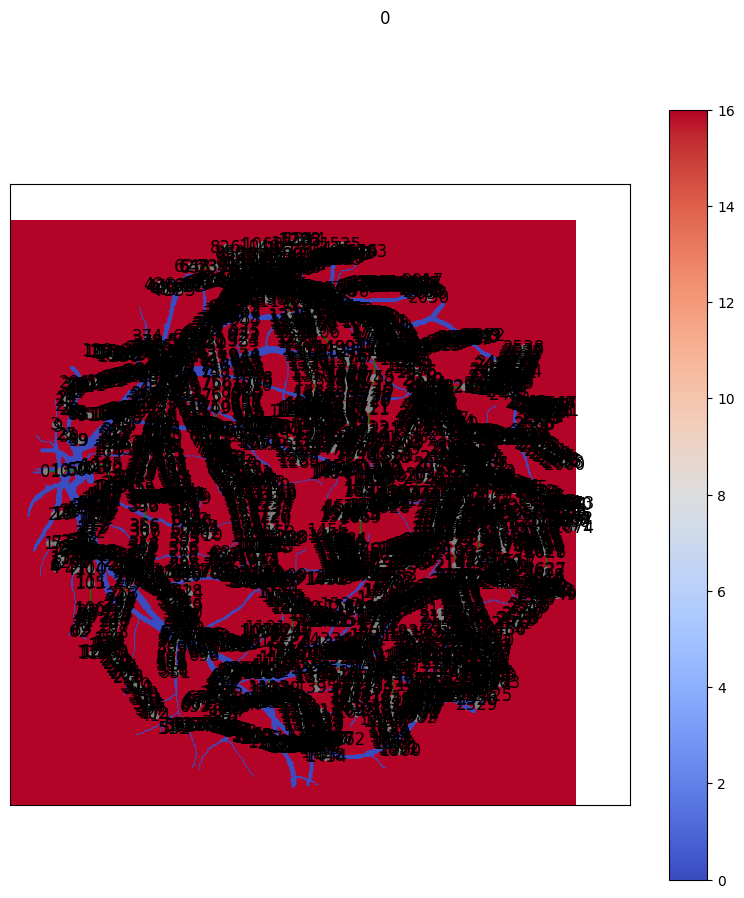


Plotting example 2:
  Label: ./drive/training/inverted_labels/22_manual1.npy
  Graph: ./drive/training/graphs/22_manual1.npy.graph


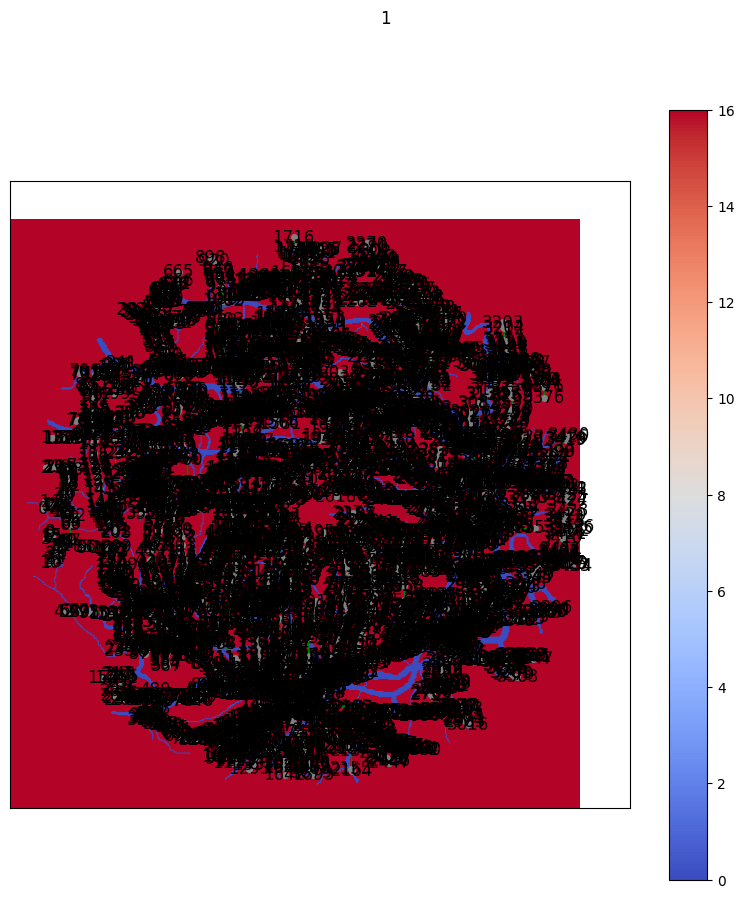


Plotting example 3:
  Label: ./drive/training/inverted_labels/23_manual1.npy
  Graph: ./drive/training/graphs/23_manual1.npy.graph


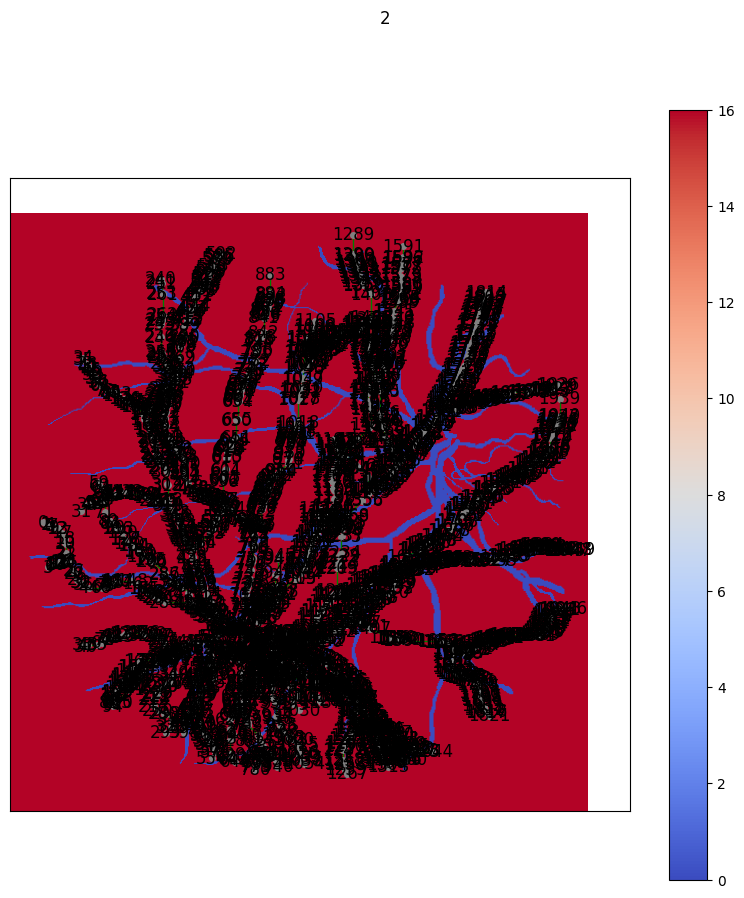

In [10]:
%pip install networkx
%pip install pyyaml
%pip install torch
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from Codes.utils import load_graph_txt


# Define directories
label_dir = "./drive/training/inverted_labels/"
graph_dir = "./drive/training/graphs/"
num_examples_to_plot = 3

# Find corresponding label and graph files
label_files = sorted(glob.glob(os.path.join(label_dir, "*.npy")))
graph_files = sorted(glob.glob(os.path.join(graph_dir, "*.npy.graph"))) # Assuming .npy.graph extension

# Ensure we have pairs
label_basenames = {os.path.basename(f).replace(".npy", ""): f for f in label_files}
graph_basenames = {os.path.basename(f).replace(".npy.graph", ""): f for f in graph_files}

common_basenames = sorted(list(label_basenames.keys() & graph_basenames.keys()))

print(f"Found {len(common_basenames)} matching label/graph pairs.")
print(f"Plotting the first {min(num_examples_to_plot, len(common_basenames))} examples...")

# Plot the first few examples
for i, basename in enumerate(common_basenames):
    if i >= num_examples_to_plot:
        break

    label_path = label_basenames[basename]
    graph_path = graph_basenames[basename]

    print(f"\nPlotting example {i+1}:")
    print(f"  Label: {label_path}")
    print(f"  Graph: {graph_path}")

    # Load label image
    label_img = np.load(label_path) # Values are 0 for vessel, 16 for background

    # Load graph
    try:
        G = load_graph_txt(graph_path)
    except ValueError as e:
        # Specifically catch the coordinate unpacking error during loading
        if "not enough values to unpack" in str(e):
            print(f"  Skipping {basename}: Error loading graph - Mismatch between expected (3) and found (2) coordinates in load_graph_txt. ({e})")
            continue # Skip this example
        else:
            raise # Re-raise other potential ValueErrors

    show(label_img, f'{i}', G)

if len(common_basenames) < num_examples_to_plot:
    print(f"\nNote: Only found {len(common_basenames)} pairs to plot.")
